In [1]:
import numpy as np
from engine import AdvRw2, AdvRwGridworld
from agent import ExpSmoother, FPLearningAgent, Level2QAgent, RandomAgent, IndQLearningAgent
from agent import Level3QAgent, Level3QAgentMixExp, Level3QAgentMixDir
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot(r0ss, r1ss, dir):
    # We set a fancy theme
    plt.style.use('ggplot')
    N_EXP = len(r0ss)
    #plt.axis([0, max_steps*n_iter, -4.5, 1.5])
    for i in range(N_EXP):
        plt.plot(moving_average(r0ss[i], 100), 'b', alpha=0.05)
        #plt.plot(moving_average(r1ss[i], 100), 'r', alpha=0.05)

    plt.plot(moving_average(np.asarray(r0ss).mean(axis=0), 100), 'b', alpha=0.5)
    #plt.plot(moving_average(np.asarray(r1ss).mean(axis=0), 100), 'r', alpha=0.5)

    plt.xlabel('t');
    plt.ylabel('R');

    from matplotlib.lines import Line2D
    cmap = plt.cm.coolwarm
    custom_lines = [Line2D([0], [0], color='b'),
                    Line2D([0], [0], color='r')]

    #plt.legend(custom_lines,['Agent A']);
    plt.savefig(dir + '.png')

In [ ]:
N_EXP = 5

r0ss = []
r1ss = []
#
for n in range(N_EXP):

    gamma = 0.9

    env = AdvRwGridworld(max_steps=50, batch_size=1)
    n_states = 12
    ##
    P2 = ExpSmoother(env.available_actions_Adv, env.available_actions_Adv, learning_rate=0.75)
    #P1 =  RandomAgent( env.available_actions, p=0.5)
    P1 = IndQLearningAgent(env.available_actions_DM, n_states, learning_rate=0.05,
                           epsilon=0.1, gamma=gamma, enemy_action_space=None)

    
    n_iter = 15000        


    r0s = []
    r1s = []
    

    for i in range(n_iter):

        # A full episode:
        done = False
        env.reset()
        s = 7

        while not done:
            
            
            episode_rewards_DM = 0

            # Agents decide
            a1 = P1.act(s)
            a2 = P2.act()
            # This is to test the neutral adversary
            #a2 = np.random.choice(2, p=[0.9, 0.1])


            # World changes
            s_new, rewards, done =  env.step([a1,a2])


            # Agents learn

            P1.update(s, [a1, a2], [rewards[0], rewards[1]], s_new)
            #P1.epsilon *= 0.99
            if s_new == 0 or s_new == 8:  # the adversary only updates after choice
                if s_new == 0:
                    P2.update(0, [a2, 0], [rewards[1], rewards[0]], 0)
                else:
                    P2.update(0, [a2, 1], [rewards[1], rewards[0]], 0)

            s = s_new  
            #print(r0, r1)
            episode_rewards_DM += rewards[0]
            r1s.append(rewards[1])

        r0s.append(episode_rewards_DM)
        env.reset()
        
    print(n)
    r0ss.append(r0s)
    r1ss.append(r0s)
    
plot(r0ss, r1ss)

In [ ]:
P1.Dir

0
[0.30349213 0.69650787]
1
[0.47615653 0.52384347]
2
[0.3485311 0.6514689]
3
[0.20441556 0.79558444]
4
[0.26770746 0.73229254]


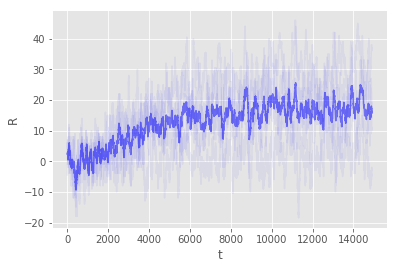

In [3]:
N_EXP = 5

r0ss = []
r1ss = []
#
for n in range(N_EXP):

    gamma = 0.8

    env = AdvRwGridworld(max_steps=100, batch_size=1)
    n_states = 12
    ##
    
    P2 = ExpSmoother(env.available_actions_Adv, env.available_actions_Adv, learning_rate=0.75)
    #P2 = Level2QAgent(env.available_actions_Adv,env.available_actions_Adv, n_states=12,
    #                   learning_rate=0.1, epsilon=0.1, gamma=gamma)
    #P1 =  RandomAgent( env.available_actions, p=0.5)
    P1 = Level3QAgentMixDir(env.available_actions_DM,[0,1,2], n_states=12, learning_rate=0.05,
                           epsilon=0.99, gamma=gamma)
    
    #P1.enemy2.alpha = 0.01

    
    n_iter = 15000        


    r0s = []
    r1s = []
    

    for i in range(n_iter):

        # A full episode:
        done = False
        env.reset()
        s = 7

        while not done:
            
            
            episode_rewards_DM = 0

            # Agents decide
            a1 = P1.act(s)
            a2 = P2.act(s)
            # This is to test the neutral adversary
            #a2 = np.random.choice(2, p=[0.9, 0.1])


            # World changes
            s_new, rewards, done = env.step([a1,a2])

            
            # Agents learn
            if s_new == 0 or s_new == 8:  # the adversary only updates after choice
                
                P1.update(s, [a1, a2], [rewards[0], rewards[1]], s_new)


                if s_new == 0:
                    P2.update(0, [a2, 0], [rewards[1], rewards[0]], 0)
                else:
                    P2.update(0, [a2, 1], [rewards[1], rewards[0]], 0)
                    

            s = s_new  
            #print(r0, r1)
            episode_rewards_DM += rewards[0]
            r1s.append(rewards[1])

        r0s.append(episode_rewards_DM)
        env.reset()
        
        if i%10 == 0:
            P1.epsilonA *= 0.995
            P1.epsilonB *= 0.9

        
    print(n)
    print(P1.prob_type/P1.prob_type.sum())
    r0ss.append(r0s)
    r1ss.append(r0s)
    
plot(r0ss, r1ss, dir='img/Level3Dir_vs_ExpSmoother')